# Ïã§ÌóòÎÇ¥Ïö©
1. LLM ÌôúÏö©ÌïòÏó¨ full-queryÎ•º sub-queryÎ°ú Î≥ÄÌôò Î∞è Í∞Å sub-queryÏùò ÏÇ¨ÏßÑ ÏÉùÏÑ± Ï§ëÏöîÎèÑ Ï∏°Ï†ï
2. Î™®Îì† ÏÑúÎ∏åÏøºÎ¶¨Ïóê ÎåÄÌï¥ Í≤ÄÏÉâÏùÑ ÏàòÌñâÌïòÏó¨ ÏÇ¨ÏßÑ Î∞òÌôò
3. Í≤ÄÏÉâÎêú ÏÇ¨ÏßÑÎì§ÎÅºÎ¶¨ ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ÌïòÏó¨ ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑÍ∞Ä ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ ÎÜíÏùÑ Í≤ΩÏö∞ Îçî Í∞ÄÏ§ëÏπòÍ∞Ä ÎÜíÏùÄ ÏÇ¨ÏßÑ ÏÑ†ÌÉù
4. ÌïÑÌÑ∞ÎßÅ Îêú ÏÇ¨ÏßÑÍ≥º ÏÑúÎ∏åÏøºÎ¶¨ÎßåÏùÑ ÌôúÏö©ÌïòÏó¨ Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±

In [34]:
# # ! pip install faiss-cpu
# ! pip install --upgrade langchain langchain-community
# ! pip install langchain_openai


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# import faiss
import json
import  torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd

import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt


In [25]:
# ÏûÑÎ≤†Îî© CLIP Î™®Îç∏ Ï†ïÎ≥¥
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# text ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ Î∞òÌôò
def encode_text(text):
    inputs = processor(text=[text], return_tensors="pt")
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #Ï†ïÍ∑úÌôî
    return text_features.cpu().numpy().astype("float32")

# Í≤ÄÏÉâ
def search_similar_images(text, image_index, top_k=5):
    text_vec = encode_text(text)
    distances, indices = image_index.search(text_vec, top_k)
    # Í∞úÎ≥Ñ Î≤°ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
    image_embed_vectors = []
    for i in indices[0]:  # Ïù¥Ï∞®Ïõê Î∞∞Ïó¥Ïù¥ÎØÄÎ°ú Ï≤´ Î≤àÏß∏ rowÏóêÏÑú Í∞ÄÏ†∏Ïò§Í∏∞
      vec = np.zeros((image_index.d,), dtype=np.float32)  # Îπà Î≤°ÌÑ∞ ÏÉùÏÑ±
      image_index.reconstruct(int(i), vec)  # ÌäπÏ†ï IDÏùò Î≤°ÌÑ∞ Î≥µÏõê
      image_embed_vectors.append(vec) # Ï†ÄÏû•
    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)
    return image_embed, distances

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# Ïù¥ÎØ∏ÏßÄ ÏûÖÎ†• Î∞õÍ∏∞

upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

# ÏóÖÎ°úÎìúÎêú Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Ï†ÄÏû•
uploaded_image_paths = []

# ColabÏóêÏÑú Ïù¥ÎØ∏ÏßÄ ÌååÏùº ÏóÖÎ°úÎìú Î∞è Ï†ÄÏû•
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # Í∏∞Î≥∏ ÏóÖÎ°úÎìú Í≤ΩÎ°ú
        move_path = os.path.join(upload_dir, file_name)  # ÏÇ¨Ïö©Ïûê ÏßÄÏ†ï ÎîîÎ†âÌÜ†Î¶¨

        # ÌååÏùºÏùÑ ÏõêÌïòÎäî ÎîîÎ†âÌÜ†Î¶¨Î°ú Ïù¥Îèô
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")


# Î≤ÑÌäº ÏÑ§Ï†ï
upload_button = widgets.Button(description="Ïù¥ÎØ∏ÏßÄ ÏóÖÎ°úÎìú")

# ÌÅ¥Î¶≠ Ïãú Ïã§Ìñâ
def on_upload_clicked(b):
    upload_images()


upload_button.on_click(on_upload_clicked)

# Ï∂úÎ†•
display(upload_button)


Button(description='Ïù¥ÎØ∏ÏßÄ ÏóÖÎ°úÎìú', style=ButtonStyle())

Saving ·Ñâ·Ö≥·Ñè·Ö≥·ÑÖ·Öµ·Ü´·Ñâ·Ö£·Ü∫ 2025-02-19 ·Ñã·Ö©·Ñí·ÖÆ 2.16.38.png to ·Ñâ·Ö≥·Ñè·Ö≥·ÑÖ·Öµ·Ü´·Ñâ·Ö£·Ü∫ 2025-02-19 ·Ñã·Ö©·Ñí·ÖÆ 2.16.38.png
Saving ·Ñâ·Ö≥·Ñè·Ö≥·ÑÖ·Öµ·Ü´·Ñâ·Ö£·Ü∫ 2025-02-19 ·Ñã·Ö©·Ñí·ÖÆ 2.16.47.png to ·Ñâ·Ö≥·Ñè·Ö≥·ÑÖ·Öµ·Ü´·Ñâ·Ö£·Ü∫ 2025-02-19 ·Ñã·Ö©·Ñí·ÖÆ 2.16.47.png
save image : /content/uploads/·Ñâ·Ö≥·Ñè·Ö≥·ÑÖ·Öµ·Ü´·Ñâ·Ö£·Ü∫ 2025-02-19 ·Ñã·Ö©·Ñí·ÖÆ 2.16.38.png
save image : /content/uploads/·Ñâ·Ö≥·Ñè·Ö≥·ÑÖ·Öµ·Ü´·Ñâ·Ö£·Ü∫ 2025-02-19 ·Ñã·Ö©·Ñí·ÖÆ 2.16.47.png


In [8]:
# DB ÏÑ§Ï†ï
import faiss
faiss_index_filename = "/content/drive/MyDrive/SDM/dog_ad.index"  # Í≥†ÌôîÏßà Î≤°ÌÑ∞db

# FAISS Ïù∏Îç±Ïä§ Î°úÎìú
db_index = faiss.read_index(faiss_index_filename)

### ÏøºÎ¶¨ Í≤ÄÏÉâ
1. queryÍ∞Ä ÎÑàÎ¨¥ Íµ¨Ï≤¥Ï†ÅÏù¥Ïñ¥ÏÑú Ï†ÅÏ†àÌïú Í≤ÄÏÉâÏùÑ Ïù¥ÎÅåÏñ¥ÎÇ¥ÏßÄ Î™ªÌï† Îïå
2. LLMÏùÑ ÌôúÏö©ÌïòÏó¨ ÏøºÎ¶¨ ÏÑ∏Î∂ÑÌôî -> Î≤°ÌÑ∞ Í≤ÄÏÉâÏóê Ï§ëÏöîÌïú Î™ÖÏÇ¨ ÏúÑÏ£ºÎ°ú ÎΩëÍ∏∞?
3. Í∞Å Î™ÖÏÇ¨Î°ú Ïó¨Îü¨ Î≤à ÎΩëÏùÄ Í∞Å ÏÇ¨ÏßÑÎì§ÏùÑ ÌôúÏö©ÌïòÏó¨ Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï
4. Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï: Ïú†ÏÇ¨ÎèÑ ÎπÑÎ°Ä + LLM CoT


- input_query summarize

In [12]:
query_text = "A cute dog wearing yellow hoodie sits on a stylish sofa, gazing around in a warm and cozy living room. Soft lighting fills the space, casting gentle shadows on the plush cushions. The atmosphere feels calm and inviting, with a sense of comfort and warmth."

In [14]:
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

os.environ["OPENAI_API_KEY"] = 'my_openai_key'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# ÌÖçÏä§Ìä∏ ÏûÖÎ†•
# input Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî© + Ï†ïÍ∑úÌôî
prompt_sum = f"""You are an expert in summarizing image descriptions for **dog clothing-focused visuals**. Your goal is to ensure the summary clearly highlights the **dog's outfit, its fit, and its key features** without unnecessary details.

- The summary should **focus entirely on the dog and its outfit**, without mentioning any human presence.
- The dog's **pose, expression, and setting** can be included, but the outfit should remain the central element.
- Emphasize details such as **fabric, fit, comfort, and style** to ensure clarity in the final image.
- Keep the summary **concise yet descriptive**, ensuring that the dog's outfit and its visual impact are well captured.

**Example Input:**
"A fluffy poodle wears a snug red sweater, sitting comfortably on a soft blanket. The sweater‚Äôs knitted texture and warm material make the dog look cozy and stylish. The dim lighting casts a gentle glow, enhancing the warm atmosphere."

**Example Output:**
"A poodle wearing red sweater sits on a soft blanket, highlighting its warm knitted texture and cozy fit."

Now, summarize the following description while ensuring the dog's outfit remains the primary focus:
{query_text}
"""

response = llm.invoke(prompt_sum)
summarized_query_text= response.content


In [ ]:
summarized_query_text


'A dog sits on a cushion, showcasing a stylish navy collar adorned with beige leather details. The collar features a gold-tone buckle and a matching tag, emphasizing its fashionable design.'

- weight + sub-query

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import List
import json

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# JSON Ï∂úÎ†• ÌååÏÑúÎ•º Ï†ïÏùò
class SubQuery(BaseModel):
    query: str = Field(description="ÏÑúÎ∏åÏøºÎ¶¨ ÎÇ¥Ïö©")
    weight: float = Field(description="ÏÑúÎ∏åÏøºÎ¶¨Ïùò Ï§ëÏöîÎèÑ (0~1 Î≤îÏúÑ)")

class SubQueryOutput(BaseModel):
    subqueries: List[SubQuery]

parser = JsonOutputParser(pydantic_object=SubQueryOutput)

# ÏÑúÎ∏åÏøºÎ¶¨ ÏÉùÏÑ± Ìï®Ïàò
def generate_subqueries(query_text):
    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert in **image generation and semantic search optimization**.\n\n"
            "Given the **input query**, extract the essential components that define the scene.\n"
            "Then, generate **concise subqueries** that capture the **key visual elements** of the image.\n\n"
            "Each subquery should:\n"
            "- Represent a distinct aspect of the scene (e.g., objects, actions, attributes).\n"
            "- Be **standalone** and **not depend on other subqueries**.\n"
            "- Include a **weight** (between 0 and 1) based on its importance for image generation.\n"
            "- The total sum of weights **must be exactly 1.0**.\n\n"
            "Return the output strictly in JSON format:\n"
            "{{\"subqueries\": [{{\"query\": \"Subquery1\", \"weight\": X.XX}}, "
            "{{\"query\": \"Subquery2\", \"weight\": X.XX}}, ...]}}\n"
        ),
        (
            "user",
            "#Format: {format_instructions}\n\n"
            "#Question: {query_text}"
        ),
    ]
).partial(format_instructions=parser.get_format_instructions())

    chain = prompt | llm | parser  # Ï≤¥Ïù∏ Íµ¨ÏÑ±
    return chain.invoke({"query_text": query_text})

result = generate_subqueries(query_text)
# print(json.dumps(result.dict(), indent=4, ensure_ascii=False))


In [18]:
result

{'subqueries': [{'query': 'A cute dog wearing a yellow hoodie',
   'weight': 0.35},
  {'query': 'A stylish sofa', 'weight': 0.25},
  {'query': 'Warm and cozy living room', 'weight': 0.2},
  {'query': 'Soft lighting casting gentle shadows', 'weight': 0.1},
  {'query': 'Plush cushions', 'weight': 0.1}]}

In [19]:
query_list = [item['query'] for item in result['subqueries']]
weight_list = [item['weight'] for item in result['subqueries']]

In [ ]:
weight_list

[0.25, 0.15, 0.15, 0.25, 0.2]

### ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≤ÄÏÉâ

In [21]:
import faiss
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# FAISS Ïù∏Îç±Ïä§ Î°úÎìú (L2 Í∏∞Î∞ò Ïù∏Îç±Ïä§)
faiss_index_filename = "/content/drive/MyDrive/SDM/dog_ad.index"
db_index = faiss.read_index(faiss_index_filename)

# üîπ Í∏∞Ï°¥ L2 Ïù∏Îç±Ïä§Î•º Inner Product(IP) Í∏∞Î∞ò Ïù∏Îç±Ïä§Î°ú Î≥ÄÌôò
# FAISS ÎÇ¥Ï†Å Í∏∞Î∞ò Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±ÌïòÍ≥†, L2 Ï†ïÍ∑úÌôîÌïòÏó¨ Ï†ÅÏö©
dimension = db_index.d  # Î≤°ÌÑ∞ Ï∞®Ïõê (Ïòà: 768)
new_index = faiss.IndexFlatIP(dimension)  # Inner Product Í∏∞Î∞ò Ïù∏Îç±Ïä§ ÏÉùÏÑ±

# üîπ Í∏∞Ï°¥ Î≤°ÌÑ∞Î•º Ï†ïÍ∑úÌôîÌïú ÌõÑ ÏÉà Ïù∏Îç±Ïä§Ïóê Ï∂îÍ∞Ä
vectors = np.zeros((db_index.ntotal, dimension), dtype=np.float32)
for i in range(db_index.ntotal):
    db_index.reconstruct(i, vectors[i])  # Í∏∞Ï°¥ Î≤°ÌÑ∞ Î≥µÏõê
faiss.normalize_L2(vectors)  # üîπ L2 Ï†ïÍ∑úÌôî Ï†ÅÏö©
new_index.add(vectors)  # Î≥ÄÌôòÎêú Ïù∏Îç±Ïä§Î•º FAISSÏóê Ï∂îÍ∞Ä

# üîπ ÏÉà Ïù∏Îç±Ïä§Î°ú Í≤ÄÏÉâÌï† Ïàò ÏûàÎèÑÎ°ù ÍµêÏ≤¥
db_index = new_index

# üîπ Ïù¥ÎØ∏ÏßÄ ÌååÏùº Í≤ΩÎ°ú Î°úÎìú
image_paths_filename = "/content/drive/MyDrive/SDM/dog_ad.pkl"
with open(image_paths_filename, "rb") as f:
    image_paths = pickle.load(f)


In [22]:
def search_similar_images_cosine(text, image_index, image_paths, top_k=5):
    """ÏûÖÎ†• ÌÖçÏä§Ìä∏ÏôÄ Í∞ÄÏû• Ïú†ÏÇ¨Ìïú Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî©ÏùÑ Í≤ÄÏÉâÌïòÎäî Ìï®Ïàò"""

    text_vec = encode_text(text)  # üîπ 768Ï∞®Ïõê ÌÖçÏä§Ìä∏ Î≤°ÌÑ∞Ìôî
    text_vec = text_vec / np.linalg.norm(text_vec)  # üîπ Í≤ÄÏÉâ Î≤°ÌÑ∞ Ï†ïÍ∑úÌôî (L2 Normalization)

    distances, indices = image_index.search(text_vec, top_k)  # üîπ FAISS Í≤ÄÏÉâ

    # üîπ Í≤ÄÏÉâÎêú Ïù¥ÎØ∏ÏßÄÏùò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ Î≥µÏõê
    image_embeddings = []
    for i in indices[0]:  # Í≤ÄÏÉâÎêú Ïù¥ÎØ∏ÏßÄ ID Î¶¨Ïä§Ìä∏
        vec = np.zeros((image_index.d,), dtype=np.float32)  # Îπà Î≤°ÌÑ∞ ÏÉùÏÑ± (FAISSÏóêÏÑú Î≤°ÌÑ∞ Î≥µÏõêÌï† Í≥µÍ∞Ñ)
        image_index.reconstruct(int(i), vec)  # üîπ ÌäπÏ†ï IDÏùò Î≤°ÌÑ∞ Î≥µÏõê
        image_embeddings.append(vec)

    # üîπ NumPy Î∞∞Ïó¥ ‚Üí Torch Tensor Î≥ÄÌôò
    image_embeddings_tensor = torch.tensor(np.array(image_embeddings), dtype=torch.float32)

    return image_embeddings_tensor, distances  # üîπ Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî©Í≥º Í±∞Î¶¨ Î∞òÌôò


In [23]:
# Í≤ÄÏÉâÎêú Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî
def display_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")  # Ï∂ï Ï†úÍ±∞
    plt.show()

# display_images(retrieved_images)

- Í±∞Î¶¨Í∏∞Î∞ò Í≤ÄÏÉâ

In [ ]:
faiss_index_filename = "/content/drive/MyDrive/SDM/dog_ad.index"
db_index = faiss.read_index(faiss_index_filename)
# üîπ Ïù¥ÎØ∏ÏßÄ ÌååÏùº Í≤ΩÎ°ú Î°úÎìú
image_paths_filename = "/content/drive/MyDrive/SDM/dog_ad.pkl"
with open(image_paths_filename, "rb") as f:
    image_paths = pickle.load(f)

In [ ]:
def search_similar_images(text, image_index, image_paths, top_k=5):
    text_vec = encode_text(text)  # üîπ ÌÖçÏä§Ìä∏ Î≤°ÌÑ∞Ìôî
    distances, indices = image_index.search(text_vec, top_k)  # üîπ FAISS Í≤ÄÏÉâ (L2 Í±∞Î¶¨ Í∏∞Î∞ò)

    # üîπ Í∞úÎ≥Ñ Î≤°ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞ & Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Ï°∞Ìöå
    image_embed_vectors = []
    retrieved_image_paths = []  # Í≤ÄÏÉâÎêú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Í≤ΩÎ°ú Ï†ÄÏû•
    for i in indices[0]:  # Ï≤´ Î≤àÏß∏ rowÏóêÏÑú Í≤ÄÏÉâÎêú Î≤°ÌÑ∞ ID Í∞ÄÏ†∏Ïò§Í∏∞
        vec = np.zeros((image_index.d,), dtype=np.float32)  # Îπà Î≤°ÌÑ∞ ÏÉùÏÑ±
        image_index.reconstruct(int(i), vec)  # ÌäπÏ†ï IDÏùò Î≤°ÌÑ∞ Î≥µÏõê
        image_embed_vectors.append(vec)  # Î≤°ÌÑ∞ Ï†ÄÏû•

        # üîπ Í≤ÄÏÉâÎêú Ïù¥ÎØ∏ÏßÄÏùò Ïã§Ï†ú ÌååÏùº Í≤ΩÎ°ú Ï∂îÍ∞Ä
        if i < len(image_paths):  # IDÍ∞Ä Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
            retrieved_image_paths.append(image_paths[i])

    # üîπ Í≤ÄÏÉâÎêú Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî©ÏùÑ Torch TensorÎ°ú Î≥ÄÌôò
    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)

    return image_embed, distances, retrieved_image_paths


In [ ]:
def display_images(image_paths, distances):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    for ax, img_path, distance in zip(axes, image_paths, distances[0]):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Distance: {distance:.4f}")  # Í±∞Î¶¨Í∞í Ï∂úÎ†•
        ax.axis("off")  # Ï∂ï Ï†úÍ±∞

    plt.show()


### ÏÉùÏÑ±

In [26]:
# ÏΩîÏÇ¨Ïù∏Ïú†ÏÇ¨ÎèÑ Í∏∞Î∞ò Í≤ÄÏÉâ
from scipy.special import softmax
import numpy as np

top_k = 1 # Í≤ÄÏÉâÌï† Ïù¥ÎØ∏ÏßÄ Í∞úÏàò

# üîπ Í∞Å ÏÑúÎ∏åÏøºÎ¶¨Ïóê ÎåÄÌï¥ FAISS Í≤ÄÏÉâ ÏàòÌñâ
subquery_results = []
for subquery in query_list:
    print(f"Searching for: {subquery}")
    similar_images_emb, distances = search_similar_images_cosine(subquery, db_index,image_paths, top_k=top_k)
    subquery_results.append((subquery, similar_images_emb, distances))

Searching for: A cute dog wearing a yellow hoodie
Searching for: A stylish sofa
Searching for: Warm and cozy living room
Searching for: Soft lighting casting gentle shadows
Searching for: Plush cushions


In [35]:
# # Í±∞Î¶¨ Í∏∞Î∞ò Í≤ÄÏÉâ
# # search_similar_images(text, image_index, image_paths, top_k=5):
# subquery_results = []
# top_k = 2
# for subquery in list(subquery_dict.keys()):
#     print(f"Searching for: {subquery}")
#     image_embed, distances, retrieved_image_paths = search_similar_images(subquery, db_index,image_paths, top_k=top_k)
#     subquery_results.append((subquery, similar_images_emb, distances))

In [ ]:
### ÎùºÏù¥Î∏åÎü¨Î¶¨ ÌååÏùº ÍµêÏ≤¥

import os
from google.colab import files

# ÍµêÏ≤¥Ìï† ÌååÏùº Í≤ΩÎ°ú
file_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

# ÌååÏùº ÏóÖÎ°úÎìú
uploaded_files = files.upload()

# ÏóÖÎ°úÎìúÎêú ÌååÏùº Ï≤òÎ¶¨
for file_name in uploaded_files.keys():
    # ÏóÖÎ°úÎìúÎêú ÌååÏùºÏù¥ Python ÌååÏùºÏù∏ÏßÄ ÌôïÏù∏
    if file_name.endswith(".py"):
        upload_file_path = os.path.join("/content", file_name)  # Colab Í∏∞Î≥∏ ÏóÖÎ°úÎìú Í≤ΩÎ°ú

        # ÌååÏùºÏùÑ diffusers Í≤ΩÎ°úÎ°ú Ïù¥ÎèôÌïòÏó¨ ÎçÆÏñ¥Ïì∞Í∏∞
        os.rename(upload_file_path, file_path)

        print(f"ÏóÖÎ°úÎìú ÏôÑÎ£å")
    else:
        print(f"ERROR")



Saving pipeline_kandinsky_prior_s.py to pipeline_kandinsky_prior_s.py
ÏóÖÎ°úÎìú ÏôÑÎ£å


In [ ]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")


model_index.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

image_encoder%2Fconfig.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

(‚Ä¶)age_processor%2Fpreprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

prior%2Fconfig.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

tokenizer%2Ftokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

### Í≤ÄÏÉâÎêú ÏÇ¨ÏßÑÎì§ Í∞ÑÏùò ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ ÎπÑÍµêÌõÑ ÏûÑÍ≥ÑÍ∞íÏùÑ ÎÑòÏùÑ Í≤ΩÏö∞ Í∞ÄÏ§ëÏπòÍ∞Ä Îçî ÎÜíÏùÄ ÏÇ¨ÏßÑÏùÑ ÏÑ†ÌÉùÌïòÎäî Î∞©Î≤ï

In [29]:
weighted_results = []
# subquery_resultsÏùò Í∞Å Ìï≠Î™©Í≥º Ïù∏Îç±Ïä§Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÏàúÏÑúÎåÄÎ°ú weightÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§.
for idx, (subquery, image_emb, distances) in enumerate(subquery_results):
    # ÏÑúÎ∏åÏøºÎ¶¨Ïùò Ï§ëÏöîÎèÑÎ•º ÏàúÏÑúÎåÄÎ°ú Í∞ÄÏ†∏Ïò¥
    weight = weight_list[idx]

    # Í±∞Î¶¨Í∞íÏùÑ Î∞∞Ïó¥Î°ú Î≥ÄÌôò ÌõÑ Ï†ïÍ∑úÌôî
    weights = np.array(distances[0])
    normalized_weights = weights / np.sum(weights)

    # ÏÑúÎ∏åÏøºÎ¶¨Ïùò Ï§ëÏöîÎèÑ(weight)Î•º Í≥±ÌïòÏó¨ ÏµúÏ¢Ö Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    top_k_w = normalized_weights * weight

    # Í≤∞Í≥º Ï†ÄÏû•
    weighted_results.append((subquery, image_emb, top_k_w.tolist()))

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from itertools import combinations

def filter_similar_images(weighted_results, similarity_threshold=0.8):
    filtered_results = []
    selected_indices = set()  # Ï†úÍ±∞Ìï† Ïù∏Îç±Ïä§ Ï†ÄÏû•

    # Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî©Í≥º Í∞ÄÏ§ëÏπò Ï∂îÏ∂ú (2D Î≥ÄÌôò)
    embeddings = np.array([np.squeeze(result[1]) for result in weighted_results])  # (n, embedding_dim)
    weights = [np.sum(result[2]) for result in weighted_results]  # Í∞Å ÏÑúÎ∏åÏøºÎ¶¨Ïùò Í∞ÄÏ§ëÏπò Ìï©ÏÇ∞

    # Î™®Îì† Í∞ÄÎä•Ìïú Ïåç Ï°∞Ìï© ÏÉùÏÑ±
    similarity_matrix = cosine_similarity(embeddings)

    print("\nAll Pairwise Similarities:")
    for i, j in combinations(range(len(weighted_results)), 2):  # Î™®Îì† Ïåç ÌÉêÏÉâ
        print(f"Similarity between {weighted_results[i][0]} and {weighted_results[j][0]}: {similarity_matrix[i, j]:.4f}")

        if i in selected_indices or j in selected_indices:
            continue  # Ïù¥ÎØ∏ ÏÑ†ÌÉùÏóêÏÑú Ï†úÏô∏Îêú Í≤ΩÏö∞ Î¨¥Ïãú

        if similarity_matrix[i, j] > similarity_threshold:  # Ïú†ÏÇ¨ÎèÑ ÏûÑÍ≥ÑÍ∞í Ï¥àÍ≥º Ïó¨Î∂Ä ÌôïÏù∏
            if weights[i] >= weights[j]:
                selected_indices.add(j)  # Í∞ÄÏ§ëÏπòÍ∞Ä ÎÇÆÏùÄ Ìï≠Î™© Ï†úÍ±∞
            else:
                selected_indices.add(i)

    # ÏµúÏ¢Ö ÏÑ†ÌÉùÎêú Ïù¥ÎØ∏ÏßÄÎßå ÌïÑÌÑ∞ÎßÅ
    for i in range(len(weighted_results)):
        if i not in selected_indices:
            filtered_results.append(weighted_results[i])

    return filtered_results

# ÌïÑÌÑ∞ÎßÅ Ï†ÅÏö©
filtered_results = filter_similar_images(weighted_results)



All Pairwise Similarities:
Similarity between A cute dog wearing a yellow hoodie and A stylish sofa: 0.5764
Similarity between A cute dog wearing a yellow hoodie and Warm and cozy living room: 0.5069
Similarity between A cute dog wearing a yellow hoodie and Soft lighting casting gentle shadows: 0.5219
Similarity between A cute dog wearing a yellow hoodie and Plush cushions: 0.6535
Similarity between A stylish sofa and Warm and cozy living room: 0.7451
Similarity between A stylish sofa and Soft lighting casting gentle shadows: 0.5712
Similarity between A stylish sofa and Plush cushions: 0.8309
Similarity between Warm and cozy living room and Soft lighting casting gentle shadows: 0.6078
Similarity between Warm and cozy living room and Plush cushions: 0.7417
Similarity between Soft lighting casting gentle shadows and Plush cushions: 0.7265


In [31]:
len(filtered_results)
[x[0] for x in filtered_results]

['A cute dog wearing a yellow hoodie',
 'A stylish sofa',
 'Warm and cozy living room',
 'Soft lighting casting gentle shadows']

In [32]:

# üîπ `similar_images_emb`ÏôÄ `top_k_w`Î•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî
similar_images_emb_list = []
top_k_w_list = []

for subquery, image_embeddings, weights in filtered_results:
    # Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî©ÏùÑ NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌïòÏó¨ Ï†ÄÏû•
    similar_images_emb_list.extend(image_embeddings.cpu().numpy())  # Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä

    # Í∞ÄÏ§ëÏπòÎèÑ NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌïòÏó¨ Ï†ÄÏû•
    top_k_w_list.extend(weights)  # Í∞ÄÏ§ëÏπòÎäî Ïù¥ÎØ∏ Î¶¨Ïä§Ìä∏ ÌòïÌÉúÏù¥ÎØÄÎ°ú Î∞îÎ°ú Ï∂îÍ∞Ä Í∞ÄÎä•

# üîπ NumPy Î∞∞Ïó¥ Î≥ÄÌôò
similar_images_emb_array = np.array(similar_images_emb_list, dtype=np.float32)  # (Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Í∞úÏàò, 768)
top_k_w_array = np.array(top_k_w_list, dtype=np.float32)  # (Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Í∞úÏàò,)

# üîπ PyTorch Tensor Î≥ÄÌôò Î∞è CUDA Ïù¥Îèô
similar_images_emb = torch.tensor(similar_images_emb_array, dtype=torch.float32).to("cuda", dtype=torch.float16)
top_k_w = torch.tensor(top_k_w_array, dtype=torch.float32).to("cuda", dtype=torch.float16)


In [ ]:
normalized_top_k_w_list = top_k_w_list / np.sum(top_k_w_list)

In [ ]:
normalized_top_k_w_list

array([0.29411764, 0.17647059, 0.29411764, 0.23529412])

In [ ]:
np.mean(normalized_top_k_w_list)
summarized_query_text
input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ Î¶¨Ïä§Ìä∏



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
10
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

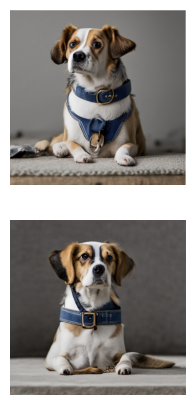

In [ ]:
# ÌÖçÏä§Ìä∏ Í∞ÄÏ§ëÏπò
# query_text_w = np.mean(normalized_top_k_w_list) # ÌèâÍ∑†
# cond_image_w = np.max(normalized_top_k_w_list) # ÏµúÎåìÍ∞í
cond_image_w=0.4
# ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄ Í∞úÏàò
num_images_per_prompt = 2

# image_text Ïª®ÎîîÏÖò Î¶¨Ïä§Ìä∏
images_texts = [x[0] for x in filtered_results]+ input_images

# Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï
weights = list(normalized_top_k_w_list)+[cond_image_w/(len(input_images)) for _ in input_images]

prompt = summarized_query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = similar_images_emb,
                                   top_k_w =normalized_top_k_w_list)

"""
Î≥ÄÏàò ÏÑ§Î™Ö
image_text : Ïù¥ÎØ∏ÏßÄ+ÌÖçÏä§Ìä∏ Ïª®ÎîîÏÖò Î¶¨Ïä§Ìä∏
weight : Ïù¥ÎØ∏ÏßÄ+ÌÖçÏä§Ìä∏ Ïª®ÎîîÏÖò Í∞ÄÏ§ëÏπò
search_k : ÏµúÍ∑ºÏ†ë Ïù¥ÎØ∏ÏßÄ kÎ•º ÏÇΩÏûÖÌï† Í≤ÉÏù∏ÏßÄ Ïó¨Î∂Ä (bool)
top_k_image : Ï∞æÏùÄ ÏµúÍ∑ºÏ†ë Ïù¥ÎØ∏ÏßÄ Î≤°ÌÑ∞
top_k_w : ÏµúÍ∑ºÏ†ë Ïù¥ÎØ∏ÏßÄ Í∞ÄÏ§ëÏπò
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_outÏùÄ image_embs + negative image embsÎ°ú Íµ¨ÏÑ±Îê®
# Ïó¨Í∏∞ÏÑúÎèÑ  Îß§Í∞úÎ≥ÄÏàò ÏßÄÏ†ï Í∞ÄÎä•
"""
num_images_per_prompt : ÏÉùÏÑ±Ìï† Ïù¥ÎØ∏ÏßÄ Í∞úÏàò
guidance_scale : prompt ÏßëÏ§ë Ï†ïÎèÑ
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_add)):
    plt.subplot(2, round(len(new_image_add)/2), i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



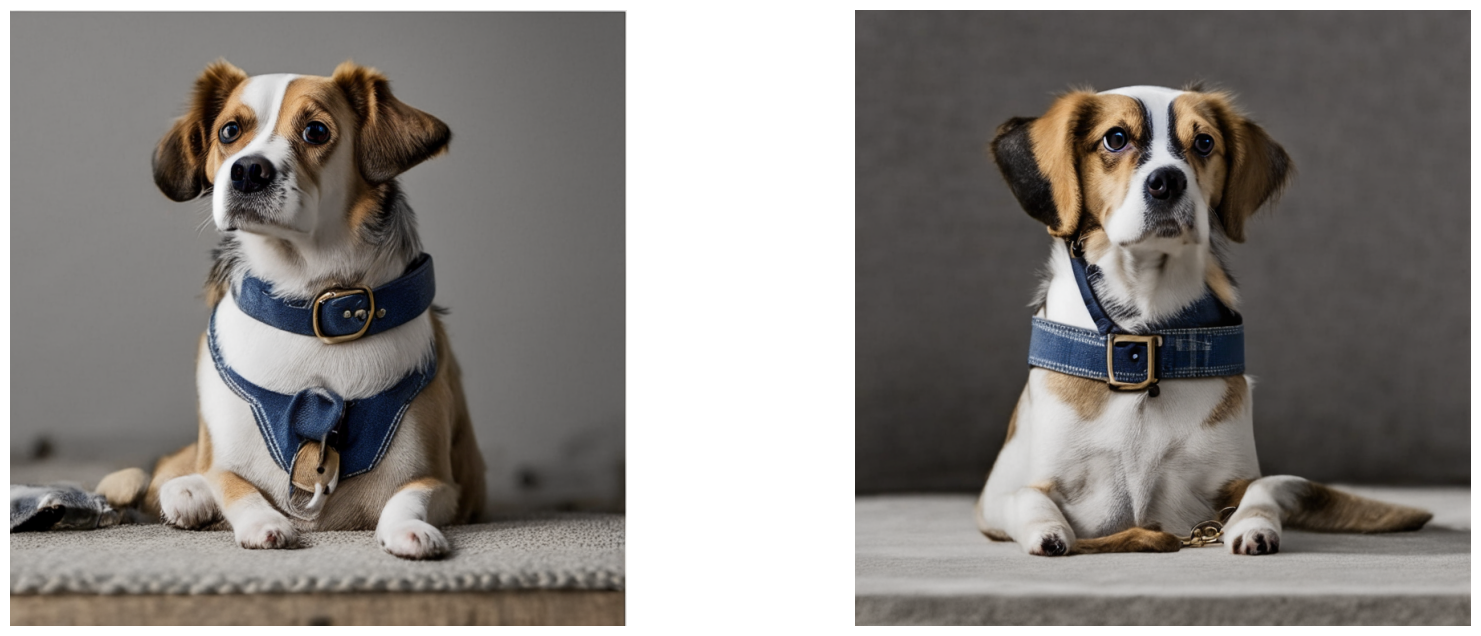

In [ ]:
if num_images_per_prompt > 1:
  plt.figure(figsize=(20,8))
  for i in range(len(new_image_add)):
    plt.subplot(round(len(new_image_add)/2),2 ,i+1 )
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



In [ ]:
# ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄ Í∞úÏàò
num_images_per_prompt = 2

prompt = query_text

negative_prompt = "low quality, bad quality" # negative ÌîÑÎ°¨ÌîÑÌä∏ Ìè¨Ìï®ÏùÄ ÏÑ†ÌÉù
image_embeds, negative_image_embeds = pipe_prior(prompt, negative_prompt).to_tuple()

new_image_onlytext = pipe(prompt, image_embeds=image_embeds, negative_image_embeds=negative_image_embeds, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images

if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_onlytext)):
    plt.subplot(2, round(len(new_image_onlytext)/2), i+1)
    plt.imshow(new_image_onlytext[i])
    plt.axis('off')
    plt.show()
else:
  plt.imshow(new_image_onlytext)
  plt.axis('off')
  plt.show()



 ## ÏÑ±Îä• ÌèâÍ∞Ä
 - clip-score

In [ ]:
# CLIP Score - text

model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# ÌÖçÏä§Ìä∏ÏôÄ ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥ Ïú†ÏÇ¨ÎèÑ ÌèâÍ∑†ÏùÑ Î∞òÌôò
def c_clip_score_text(images, prompt):
    # ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÎ•º Î≥ÄÌôò
    image_list = [image.convert("RGB") for image in images ]

    # CLIP ProcessorÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏûÖÎ†• Î≥ÄÌôò
    text_inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    image_inputs = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        text_emb = clip_model.get_text_features(**text_inputs)
        image_emb = clip_model.get_image_features(**image_inputs)  # Ïù¥ÎØ∏ÏßÄ-ÌÖçÏä§Ìä∏ Ïú†ÏÇ¨ÎèÑ Ï†êÏàò


    # Ï†ïÍ∑úÌôî
    text_emb =  torch.nn.functional.normalize(text_emb, p=2, dim=-1) # L2 Ï†ïÍ∑úÌôî
    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 Ï†ïÍ∑úÌôî

    # Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Ï∞®Ïõê ÌôïÏû•
    text_emb = text_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
    similarity = torch.nn.functional.cosine_similarity(text_emb, image_emb, dim=-1)

    return similarity.mean()  # ÌèâÍ∑†

# CLIP Score ÎπÑÍµê
clip_score_text = c_clip_score_text(new_image_onlytext, query_text)
clip_score_added_cond = c_clip_score_text(new_image_add, query_text)

print(f"CLIP Score only text: {clip_score_text:.4f}")
print(f"CLIP Score with image: {clip_score_added_cond:.4f}")


In [ ]:
# CLIP Score - image

# ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ÏôÄ ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ïùò Ïú†ÏÇ¨ÎèÑÎ•º Î∞òÌôò
def c_clip_score_image(images, input_emb):

    # ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÎ•º Î≥ÄÌôò
    image_list = [image.convert("RGB") for image in images ]

    # CLIP ProcessorÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏÉùÏÑ±Îêú Ïù¥ÎØ∏ÏßÄÎ•º Î≥ÄÌôò
    image_inputs_g = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        image_emb = clip_model.get_image_features(**image_inputs_g) # ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ ÏÉùÏÑ±


    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 Ï†ïÍ∑úÌôî

    # Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Ï∞®Ïõê ÌôïÏû•
    input_emb = input_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
    similarity = torch.nn.functional.cosine_similarity(input_emb, image_emb, dim=-1)

    return similarity.mean()  # ÌèâÍ∑† Î∞òÌôò

# ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
image_inputs = processor(images=input_images, return_tensors="pt", padding=True)
with torch.no_grad():
  image_embeddings = clip_model.get_image_features(**image_inputs)
image_embeddings =  torch.nn.functional.normalize(image_embeddings, p=2, dim=-1) # L2 Ï†ïÍ∑úÌôî

# CLIP Score ÎπÑÍµê
for i, emb in enumerate(image_embeddings):
  print(f'ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú :  {uploaded_image_paths[i]}')
  score = c_clip_score_image(new_image_add, emb)
  print(f'CLIP Score with image : {score:.4f}')

  score = c_clip_score_image(new_image_onlytext, emb)
  print(f'CLIP Score only text: {score:.4f}')

In [ ]:
uploaded_image_paths